# Flight Dalay & Cancellation Prediction

## import libraries

In [54]:
#pip install fastparquet

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import glob

## load data

In [56]:
parquet_files = glob.glob('./archive/Combined_Flights_*.parquet')
parquet_files

['./archive\\Combined_Flights_2018.parquet',
 './archive\\Combined_Flights_2019.parquet',
 './archive\\Combined_Flights_2020.parquet',
 './archive\\Combined_Flights_2021.parquet',
 './archive\\Combined_Flights_2022.parquet']

In [57]:
df = pd.DataFrame()
for f in parquet_files:
    x = pd.read_parquet(f)
    df = pd.concat([df, x], ignore_index=True)


In [ ]:
df.sample(10)

number of rows =  29193782
number of columns =  61
header 61
['FlightDate', 'Airline', 'Origin', 'Dest', 'Cancelled', 'Diverted', 'CRSDepTime', 'DepTime', 'DepDelayMinutes', 'DepDelay', 'ArrTime', 'ArrDelayMinutes', 'AirTime', 'CRSElapsedTime', 'ActualElapsedTime', 'Distance', 'Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'Marketing_Airline_Network', 'Operated_or_Branded_Code_Share_Partners', 'DOT_ID_Marketing_Airline', 'IATA_Code_Marketing_Airline', 'Flight_Number_Marketing_Airline', 'Operating_Airline', 'DOT_ID_Operating_Airline', 'IATA_Code_Operating_Airline', 'Tail_Number', 'Flight_Number_Operating_Airline', 'OriginAirportID', 'OriginAirportSeqID', 'OriginCityMarketID', 'OriginCityName', 'OriginState', 'OriginStateFips', 'OriginStateName', 'OriginWac', 'DestAirportID', 'DestAirportSeqID', 'DestCityMarketID', 'DestCityName', 'DestState', 'DestStateFips', 'DestStateName', 'DestWac', 'DepDel15', 'DepartureDelayGroups', 'DepTimeBlk', 'TaxiOut', 'WheelsOff', 'WheelsOn', 'TaxiIn

## plot the data

## 1. Distribution of Flight Delays

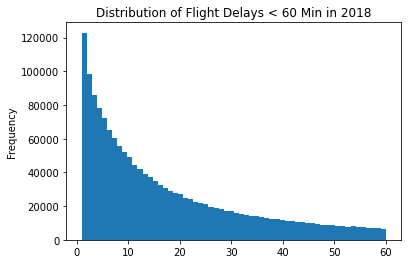

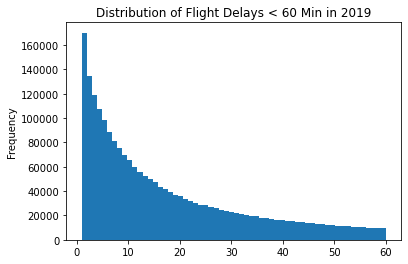

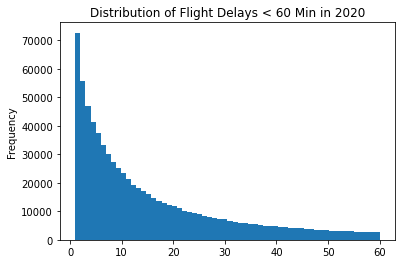

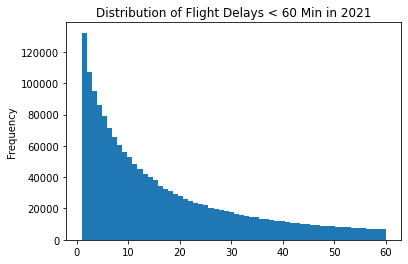

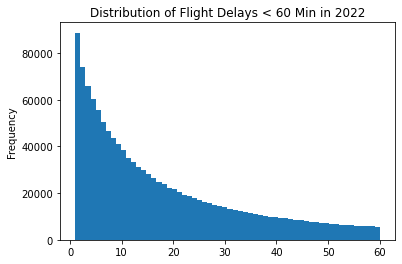

In [ ]:
years = [2018, 2019, 2020, 2021, 2022]
for year in years:
    expr = f"Year == {year} and DepDelayMinutes > 0 and DepDelayMinutes < 61"
    title = "Distribution of Flight Delays < 60 Min in " + str(year)
    df.query(expr)["DepDelayMinutes"].plot(kind="hist", bins=60, title=title)
    plt.show()

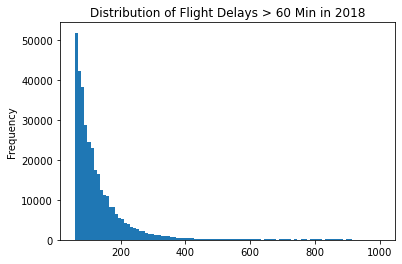

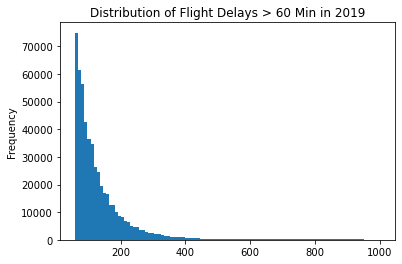

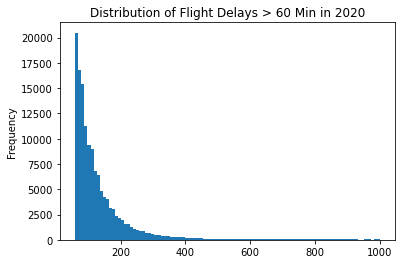

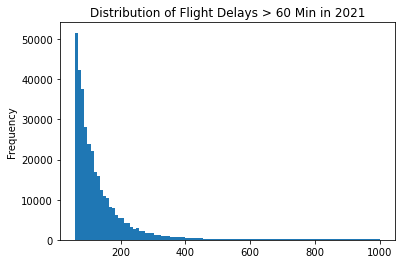

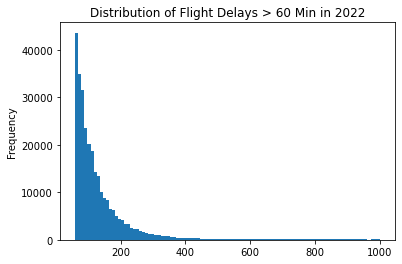

In [ ]:
for year in years:
    expr = f"Year == {year} and DepDelayMinutes >= 61"
    title = "Distribution of Flight Delays > 60 Min in " + str(year)
    df.query(expr)["DepDelayMinutes"].plot(kind="hist", bins=100, range = [60, 1000], title=title)
    plt.show()

## 2. Distribuituon of Cancellation

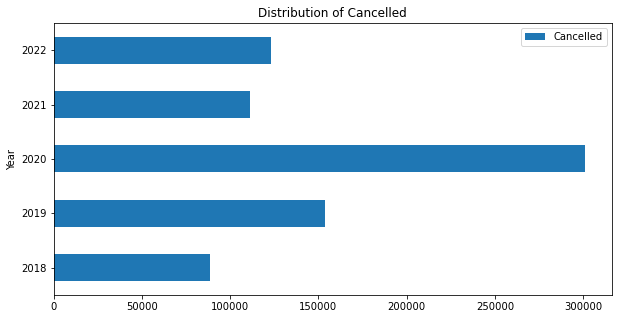

In [ ]:
x = pd.DataFrame({
    'Year':[2018, 2019, 2020, 2021, 2022],
    'Cancelled':[0, 0, 0, 0, 0]
})
x.set_index('Year', inplace = True)

for year in years:
    expr = f"Year == {year} and Cancelled == 1"
    x.loc[year] = df.query(expr)["Year"].count()
    
x.plot(kind="barh", figsize=(10, 5), title = "Distribution of Cancelled")
plt.show() 

## Preprocessign the data

## 1. Drop the columns

In [ ]:
header = df.columns.to_list()
print('clolumns before perprocessign', len(header))
print(header)

# 'CRSArrTime', 'ArrDel15', 'ArrivalDelayGroups',
# 'ArrTimeBlk', 'DistanceGroup', 'DivAirportLandings']

df = df.drop(['FlightDate'], axis=1) # Year, Month, Date will be used instead
df = df.drop(['OriginAirportSeqID', 'OriginAirportID'], axis=1) # Origin will be used instead
df = df.drop(['DepDelayMinutes', 'ArrDelayMinutes'], axis=1) # DepDelay, ArrDelay will be used instead
df = df.drop(['DOT_ID_Marketing_Airline', 'IATA_Code_Marketing_Airline', 'DOT_ID_Operating_Airline', 'IATA_Code_Operating_Airline'], axis=1) # Airline will be used instead
df = df.drop(['OriginCityMarketID'], axis=1) # OriginCityName will be used instead
df = df.drop(['OriginState', 'OriginStateName', 'OriginWac'], axis=1) # OriginStateFips will be used instead
df = df.drop(['DestAirportID', 'DestAirportSeqID'], axis=1) # Dest will be used instead
df = df.drop(['DestCityMarketID', axis=1) # DestCityName will be used instead
df = df.drop(['DestState', 'DestStateName', 'DestWac'], axis=1) # DestStateFips will be used instead
df = df.drop(['DepDel15'], axis=1) # DepDelay will be used instead
df = df.drop(['DepTimeBlk'], axis=1) # 

header = df.columns.to_list()
print('columns after preprocessing', len(header))
print(header)

## 2. Label encoding

## 3. Scaling

## Stratified Sampling the dataset for dimension reduction

## 1. classification the dataset with amount of delay

In [ ]:
df['OnTime'] = df['DepDelayMinutes'] == 0
df['Delay15'] = (df['DepDelayMinutes'] <= 15) & (df['DepDelayMinutes'] > 0)
df['Delay45'] = (df['DepDelayMinutes'] <= 45) & (df['DepDelayMinutes'] > 15)
df['Delay180'] = (df['DepDelayMinutes'] <= 180) & (df['DepDelayMinutes'] > 45)
df['HugeDelay'] = df['DepDelayMinutes'] > 180

# If Cancelled it should not be marked as having a delay
df.loc[df['Cancelled'], 'OnTime'] = False
df.loc[df['Cancelled'], 'Delay15'] = False
df.loc[df['Cancelled'], 'Delay45'] = False
df.loc[df['Cancelled'], 'Delay180'] = False
df.loc[df['Cancelled'], 'HugeDelay'] = False

# Turn into single categorical column
df['Status'] = df[['Cancelled','OnTime','Delay15','Delay45','Delay180','HugeDelay']].idxmax(1).astype('category')

# Drop the columns madw for classification
df = df.drop(['Cancelled', 'OnTime', 'Delay15', 'Delay45', 'Delay180', 'HugeDelay'], axis=1)

df['Status'].value_counts()

OnTime       19240509
Delay15       4434918
Delay45       2515582
Delay180      1918064
Cancelled      778380
HugeDelay      306329
Name: Status, dtype: int64

## 2. balancing the dataset

In [ ]:
df = df.groupby('Status', group_keys=False).apply(lambda x: x.sample(100000))
df['Status'].value_counts()

Cancelled    100000
Delay15      100000
Delay180     100000
Delay45      100000
HugeDelay    100000
OnTime       100000
Name: Status, dtype: int64

## Dimension Reduction

In [ ]:
pca = PCA(n_components=5)
principalComponents = pca.fit_transform(df)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2','principal component 3','principal component 4','principal component 5'])
principalDf

MemoryError: Unable to allocate 40.2 GiB for an array with shape (8984, 600000) and data type object